#Proyecto final Computación Blanda
##Reconocimiento Facial usando Redes Neuronales y Máquinas de Vectores de Soporte

Se debe mencionar que, aunque se colocaron random_state y semillas, el desempeño varía cada vez que se ejecuta, sin embargo, los resultados entre si son muy similares y pueden ser usados para el análisis

###Se carga el data set y las librerías necesarias para el desarrollo del proyecto

In [0]:
from sklearn.datasets import fetch_lfw_people
import numpy as np
from matplotlib import  pyplot as plt 
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.decomposition import PCA


In [0]:
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

In [0]:
print(lfw_people.target_names)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Tony Blair']


In [0]:
data = lfw_people.data 
target = lfw_people.target
n_samples, h, w = lfw_people.images.shape
n_features = data.shape[1]
print(data.shape)

(1288, 1850)


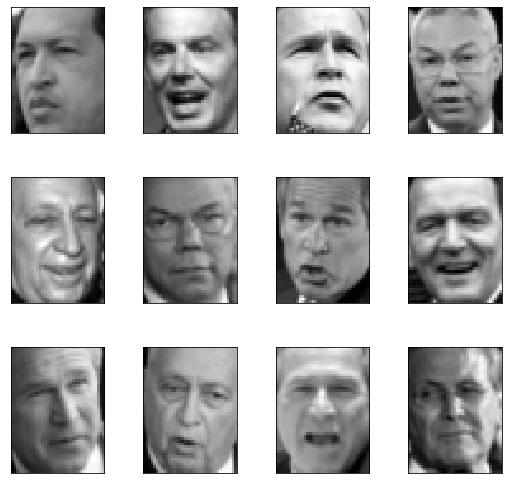

In [0]:
def plot_gallery(images, h, w, n_row=3, n_col=4, titles = None):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        if titles is not None:
          plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())


normal = data.reshape(n_samples,  h, w)
normal = normal/255
plot_gallery(normal, h, w)



##Parte 1: Redes Neuronales
Prueba de 5 distintas configuraciones de hiperparámetros.

In [0]:
from sklearn.neural_network import MLPClassifier
from tensorflow.keras import layers 
from tensorflow.keras import Model

In [0]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(data, target, test_size = 0.2, random_state = 51)
Xtrain = Xtrain/255.
print(Xtrain.shape, Xtest.shape)

(1030, 1850) (258, 1850)


###Se hace una primera aproximación sin extraer características  a través de capas de convolución y pooling
#####Aunque no se extraigan las características  a partir de las capas de convolución, estas son extraidas a través de PCA 
En esta aproximación es posible variar los hiperparámetros de una manera sencilla a partir de la utilidad 'GridSearchCV', la cual realiza todas las combinaciones de hiperparámetros dados en el diccionario *param_grid*. 

Esto ocasiona que el tiempo de ejecución sea muy alto, pero también podrá entregar así la mejor combinación, ya que se prueban muchas arquitecturas para la red. Anteriormente se tenía un mayor número de valores para los hiperparámetros, pero el tiempo de ejecución se volvía inaceptable para realizar las pruebas necesarias.

(1030, 220)


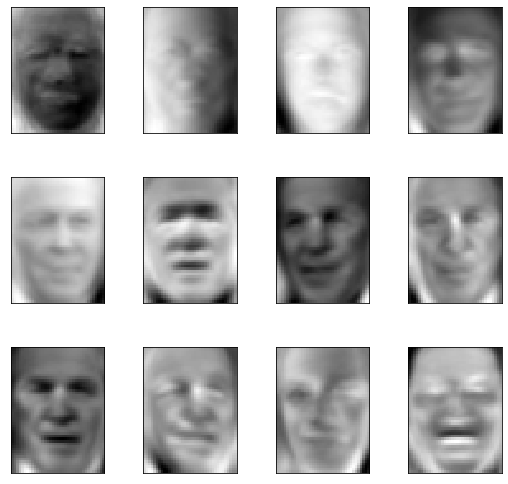

In [0]:
from sklearn.decomposition import PCA
Xtrain, Xtest, Ytrain, Ytest = train_test_split(data, target, test_size = 0.2, random_state = 51)
Xtrain = Xtrain/255.
n_components = 220

pca = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True).fit(Xtrain)

eigenfaces = pca.components_.reshape((n_components, h, w))
plot_gallery(eigenfaces, h, w)
X_train_pca = pca.transform(Xtrain)
X_test_pca = pca.transform(Xtest)
print(X_train_pca.shape)

In [0]:
print(data.shape)
#modelNN = MLPClassifier(solver = 'lbfgs',  hidden_layer_sizes=(512))

(1288, 1850)


In [0]:
param_grid = {
    'hidden_layer_sizes' : [(128, 128), (64, 64, 64), (512)],
    #'activation' : ['tanh', 'relu'], #, 'logistic']
    #'solver' : ['adam', 'lbfgs'],
    'alpha' : [0.001, 0.0001],
    #'learning_rate' : ['constant', 'invscaling'],
    'learning_rate_init' : [0.1, 0.001],
}
param_grid_pruebas = {
    'alpha' : [0.01, 0.001]
}
clf = GridSearchCV(MLPClassifier(solver = 'adam', alpha = 0.001, random_state= 51,
                                 hidden_layer_sizes=(512), 
                                 learning_rate_init=0.001), 
                   param_grid=param_grid_pruebas, cv = 5)
#clf = GridSearchCV(MLPClassifier(solver = 'adam', max_iter = 400, 
#                                 random_state = 51), param_grid, cv = 5)
clf = clf.fit(X_train_pca, Ytrain)
#modelNN.fit(Xtrain, Ytrain)

In [0]:
print("Mejor estimador:")
print(clf.best_estimator_)


yPred = clf.predict(X_test_pca)
print("Accuracy =", accuracy_score(Ytest, yPred))
print("Confusion Matrix = \n", confusion_matrix(Ytest, yPred))

Mejor estimador:
MLPClassifier(activation='relu', alpha=0.01, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=512, learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=51, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)
Accuracy = 0.7093023255813954
Confusion Matrix = 
 [[ 5  1  3  4  1  0  0]
 [ 0 27  1  4  0  0 13]
 [ 0  0 20  3  0  1  1]
 [ 0  2  4 95  0  0  5]
 [ 0  1  2  6  8  0  5]
 [ 0  1  1  6  3  4  6]
 [ 0  0  0  1  0  0 24]]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: This function is deprecated. Please call randint(0, 257 + 1) instead
  """


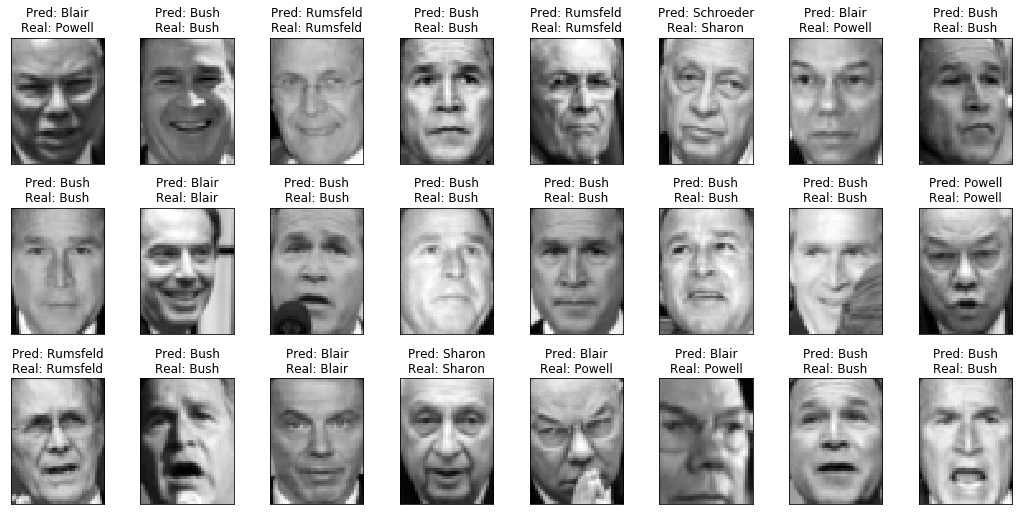

In [0]:
target_names = lfw_people.target_names
def titles(yPredecido, yReal):
  titles = []
  for i in range(yPredecido.shape[0]):
    pred = target_names[yPredecido[i]].rsplit(' ', 1)[-1]
    real = target_names[yReal[i]].rsplit(' ', 1)[-1]
    titles.append("Pred: " + pred + "\nReal: " + real)
  return titles 

titulos = titles(yPred, Ytest)
plot_gallery(Xtest, h, w, titles=titulos, n_col= 8)

##Análisis 

Antes de realizar PCA, se realizó la estimación la cual dio un accuracy de 82%, sin embargo, luego de agregar la extracción de características bajó de manera sustancial, esto era de esperarse pues se pasó de 1850 características a menos de 300. 

Cuando se incrementa el número de componentes, se puede ver un incremento en el accuracy, siendo así directamente proporcional hasta 220 características, luego de esto, el accuracy comienza a decrementar, es de importancia recalcar que, aunque se haya fijado un *random_state*, los resultados varian, por lo que la disminución luego de 220 características puede no darse en el momento de ejecutar. 

La disminución del accuracy ouede deberse a que se están tomando características que no son relevantes en el reconocimiento del rostro.

A continuación se muestra una tabla en la cual se registra los efectos de variar el número de componentes principales a seleccionar. 


Número de componentes | Accuracy con el mejor estimador
---|---
150 | 0.70155
170 | 0.71705
190 | 0.736434
220 | 0.763565
250 | 0.751937
280 | 0.705426

$\bf{\mu}_{acc} = 0.729327$

$\bf{\sigma}_{acc} = 0.023193$

###Se realiza una segunda aproximación con 3 capas de convolución y pooling y una capa densa de 512 neuronas

En el código, en cada capa se proporciona una breve explicación de lo que se está realizando 

In [0]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(data, target, test_size = 0.2, random_state = 51)
Xtrain = Xtrain/255.
Xtrain = Xtrain.reshape(1030, h, w, 1)

In [0]:
#ARQUITECTURA
from tensorflow.keras.optimizers import RMSprop

# 50x37 Es el tamanio de la imagen
img_input = layers.Input(shape=(50, 37, 1))

#16 filtros de 3x3 con un pooling de 2x2
x = layers.Conv2D(16, 3,activation='relu')(img_input)
x = layers.MaxPooling2D(2)(x)

#16 filtros de 3x3 con un pooling de 2x2
x = layers.Conv2D(32,3,activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

#16 filtros de 3x3 con un pooling de 2x2
x = layers.Convolution2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

# 'Aplastar' el valor de x para que quede en un supervector de una dimension
x = layers.Flatten()(x)

# Capa de la red neuronal comun y corriente, como es conocida
x = layers.Dense(512, activation='relu')(x)

# Droput de 0.5
x = layers.Dropout(0.5)(x)

# Salida de la red neuronal, tiene 7 salidas ya que, al usar la funcion de perdida  
#"categorical_crossentropy" fue necesario pasar los tags a notacion 1 de K.
output = layers.Dense(7, activation='sigmoid')(x)

# Compilar el modelo 
model1 = Model(img_input, output)
model1.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=0.001),
              metrics=['acc'])

In [0]:
#Resumen del número de parámetros 
model1.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 50, 37, 1)]       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 48, 35, 16)        160       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 24, 17, 16)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 22, 15, 32)        4640      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 11, 7, 32)         0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 9, 5, 64)          18496     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 4, 2, 64)          0   

In [0]:
#ENTRENAMIENTO
from keras.utils import to_categorical
#Paso de los tags de notacion entera a notacion 1 de K 
categorical_labels = to_categorical(Ytrain, num_classes=7)

#Entrenamiento del modelo
model1.fit(Xtrain, categorical_labels, epochs = 30)

Train on 1030 samples
Epoch 1/30
1030/1030 [==============================] - 1s 1ms/sample - loss: 1.7249 - acc: 0.4019
Epoch 2/30
1030/1030 [==============================] - 1s 1ms/sample - loss: 1.7010 - acc: 0.4117
Epoch 3/30
1030/1030 [==============================] - 1s 1ms/sample - loss: 1.6784 - acc: 0.4117
Epoch 4/30
1030/1030 [==============================] - 1s 1ms/sample - loss: 1.6718 - acc: 0.4117
Epoch 5/30
1030/1030 [==============================] - 1s 1ms/sample - loss: 1.6397 - acc: 0.4117
Epoch 6/30
1030/1030 [==============================] - 1s 1ms/sample - loss: 1.5733 - acc: 0.4117
Epoch 7/30
1030/1030 [==============================] - 1s 1ms/sample - loss: 1.4411 - acc: 0.4456
Epoch 8/30
1030/1030 [==============================] - 1s 1ms/sample - loss: 1.3121 - acc: 0.5301
Epoch 9/30
1030/1030 [==============================] - 1s 1ms/sample - loss: 1.1973 - acc: 0.5699
Epoch 10/30
1030/1030 [==============================] - 1s 1ms/sample - loss: 1.0996 -

In [0]:
#PREDICCION
Xtest = Xtest/255.
Xtest = Xtest.reshape((Xtest.shape[0], h, w, 1))

Ypred = model1.predict(Xtest)
#Volverlo de notacion 1 de K a  notacion entera

Ypred_entero = []
for value in Ypred:
  Ypred_entero.append(np.argmax(value))

#print(Ypred_entero)


Conf mat: 
 [[ 8  1  3  0  1  0  1]
 [ 0 43  0  2  0  0  0]
 [ 2  0 22  1  0  0  0]
 [ 0  4  1 95  0  4  2]
 [ 2  0  8  2  7  1  2]
 [ 0  1  2  3 10  3  2]
 [ 0  2  5  2  3  0 13]]
Accuracy = 0.7403100775193798


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: This function is deprecated. Please call randint(0, 257 + 1) instead
  """


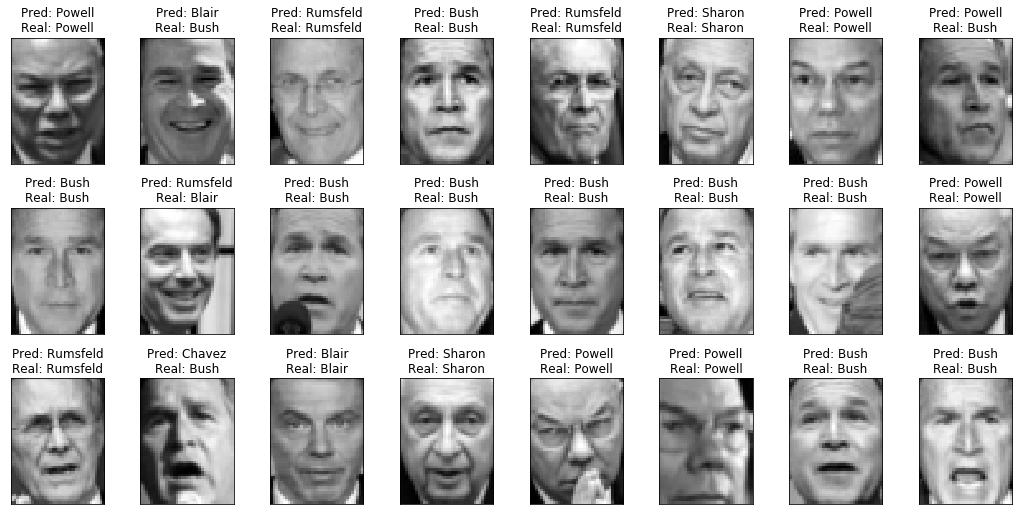

In [0]:
#TESTING
acc = accuracy_score(Ytest ,Ypred_entero)
print("Conf mat: \n", confusion_matrix(Ytest, Ypred_entero))
print("Accuracy =", acc)

titulos = titles(np.asarray(Ypred_entero), Ytest)
plot_gallery(Xtest, h, w, titles=titulos, n_col= 8)

####Análisis 
Para la anterior arquitectura, en 30 épocas se obtuvo un Accuracy en el entrenamiento de 92.02% y en el testing de 85.6589%, los cuales pueden ser considerados unos buenos resultados. 

No es comparable este modelo (y los siguientes con capas de convolución) con el modelo inicial ya que en este se cuenta con muchos más parámetros que el anterior, donde, a la capa de la red neuronal normal luego de las capas de convolución y pooling le ingresan más de 18 mil parámetros, a diferencia del otro donde inicia con alrededor de 200 parámetros. 

### Se realiza una tercera aproximación con 2 capas de convolución y una capa densa de 1024 neuronas

También se modificó el valor de Dropout el cual repercute en el overfitting.

In [0]:
#ARQUITECTURA Y ENTRENAMIENTO
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D

	
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)
Xtrain, Xtest, Ytrain, Ytest = train_test_split(data, target, test_size = 0.2, random_state = 51)
Xtrain = Xtrain/255.
Xtrain = Xtrain.reshape(1030, h, w, 1)
model2 = Sequential()


model2.add(Conv2D(16, 3, activation = "relu"))
model2.add(MaxPooling2D(2))


model2.add(Conv2D(32, 3, activation = "relu"))
model2.add(MaxPooling2D(2))

model2.add(Conv2D(64, 3, activation = "relu"))
model2.add(MaxPooling2D(2))



model2.add(Flatten())
model2.add(Dense(1024))


model2.add(Dropout(0.3))
model2.add(Dense(7, activation='sigmoid'))

model2.compile(loss = "categorical_crossentropy", optimizer="adam", metrics = ["accuracy"])

categorical_labels = to_categorical(Ytrain, num_classes=7)
#print(categorical_labels[:10], Ytrain[:10])

print(Xtrain.shape)
model2.fit(Xtrain, categorical_labels, epochs = 25)

(1030, 50, 37, 1)
Train on 1030 samples
Epoch 1/25
1030/1030 [==============================] - 2s 2ms/sample - loss: 1.7159 - acc: 0.4068
Epoch 2/25
1030/1030 [==============================] - 2s 1ms/sample - loss: 1.6852 - acc: 0.4117
Epoch 3/25
1030/1030 [==============================] - 2s 1ms/sample - loss: 1.6715 - acc: 0.4117
Epoch 4/25
1030/1030 [==============================] - 1s 1ms/sample - loss: 1.5901 - acc: 0.4117
Epoch 5/25
1030/1030 [==============================] - 2s 1ms/sample - loss: 1.3817 - acc: 0.5058
Epoch 6/25
1030/1030 [==============================] - 2s 1ms/sample - loss: 1.1068 - acc: 0.6291
Epoch 7/25
1030/1030 [==============================] - 1s 1ms/sample - loss: 0.9148 - acc: 0.6990
Epoch 8/25
1030/1030 [==============================] - 1s 1ms/sample - loss: 0.7437 - acc: 0.7495
Epoch 9/25
1030/1030 [==============================] - 2s 2ms/sample - loss: 0.5996 - acc: 0.8107
Epoch 10/25
1030/1030 [==============================] - 2s 2ms/sampl

Conf mat: 
 [[10  1  0  3  0  0  0]
 [ 0 41  0  2  1  0  1]
 [ 0  0 21  2  2  0  0]
 [ 0  1  2 99  1  1  2]
 [ 0  0  2  3 16  0  1]
 [ 0  0  0  1  1 19  0]
 [ 0  2  1  2  1  0 19]]
Accuracy = 0.872093023255814


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: This function is deprecated. Please call randint(0, 257 + 1) instead
  """


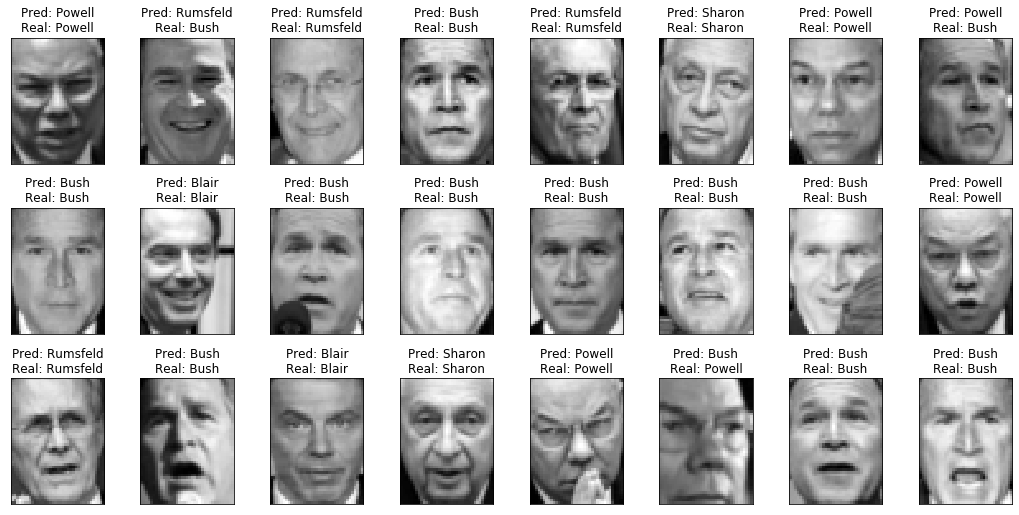

In [0]:
#PREDICCION Y TESTING
Xtest = Xtest/255.
Xtest = Xtest.reshape((Xtest.shape[0], h, w, 1))

Ypred = model2.predict(Xtest)
#Volverlo de notacion 1 de K a  notacion entera

Ypred_entero = []
for value in Ypred:
  Ypred_entero.append(np.argmax(value))

acc = accuracy_score(Ytest ,Ypred_entero)
print("Conf mat: \n", confusion_matrix(Ytest, Ypred_entero))
print("Accuracy =", acc)

titulos = titles(np.asarray(Ypred_entero), Ytest)
plot_gallery(Xtest, h, w, titles=titulos, n_col= 8)

####Análisis 
Para la anterior arquitectura, en 27 épocas se obtuvo un Accuracy en el entrenamiento de 99.71% y en el testing de 83.7209%, los cuales también son buenos resultados.

###Por último, se realiza una cuarta aproximación modificando el número de capas densas y el número de neuronas en cada capa


In [0]:
from tensorflow.keras.optimizers import RMSprop
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)
Xtrain, Xtest, Ytrain, Ytest = train_test_split(data, target, test_size = 0.2, random_state = 51)
Xtrain = Xtrain/255.
Xtrain = Xtrain.reshape(1030, h, w, 1)
img_input3 = layers.Input(shape=(50, 37, 1))


x = layers.Conv2D(16, 3,activation='relu')(img_input3)
x = layers.MaxPooling2D(2)(x)


x = layers.Conv2D(32,3,activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

x = layers.Convolution2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)


x = layers.Flatten()(x)

x = layers.Dense(64, activation='relu')(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(128, activation='relu')(x)


x = layers.Dropout(0.4)(x)


output3 = layers.Dense(7, activation='sigmoid')(x)
 
model3 = Model(img_input3, output3)
model3.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=0.001),
              metrics=['acc'])


categorical_labels = to_categorical(Ytrain, num_classes=7)
#print(categorical_labels[:10], Ytrain[:10])
model3.fit(Xtrain, categorical_labels, epochs = 30)

Train on 1030 samples
Epoch 1/30
1030/1030 [==============================] - 2s 2ms/sample - loss: 1.7627 - acc: 0.4068
Epoch 2/30
1030/1030 [==============================] - 1s 1ms/sample - loss: 1.7129 - acc: 0.4117
Epoch 3/30
1030/1030 [==============================] - 1s 1ms/sample - loss: 1.7069 - acc: 0.4117
Epoch 4/30
1030/1030 [==============================] - 1s 1ms/sample - loss: 1.7013 - acc: 0.4117
Epoch 5/30
1030/1030 [==============================] - 1s 1ms/sample - loss: 1.6950 - acc: 0.4117
Epoch 6/30
1030/1030 [==============================] - 1s 1ms/sample - loss: 1.6741 - acc: 0.4117
Epoch 7/30
1030/1030 [==============================] - 1s 1ms/sample - loss: 1.6235 - acc: 0.4117
Epoch 8/30
1030/1030 [==============================] - 1s 1ms/sample - loss: 1.5418 - acc: 0.4107
Epoch 9/30
1030/1030 [==============================] - 1s 1ms/sample - loss: 1.4055 - acc: 0.4718
Epoch 10/30
1030/1030 [==============================] - 1s 1ms/sample - loss: 1.2684 -

Conf mat: 
 [[  5   1   0   2   1   4   1]
 [  2  36   0   6   0   0   1]
 [  0   0   6   7  10   1   1]
 [  1   0   0 102   0   3   0]
 [  0   0   0   3   8  10   1]
 [  0   0   0   4   0  17   0]
 [  0   1   0   3   1  12   8]]
Accuracy = 0.7054263565891473


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: This function is deprecated. Please call randint(0, 257 + 1) instead
  """


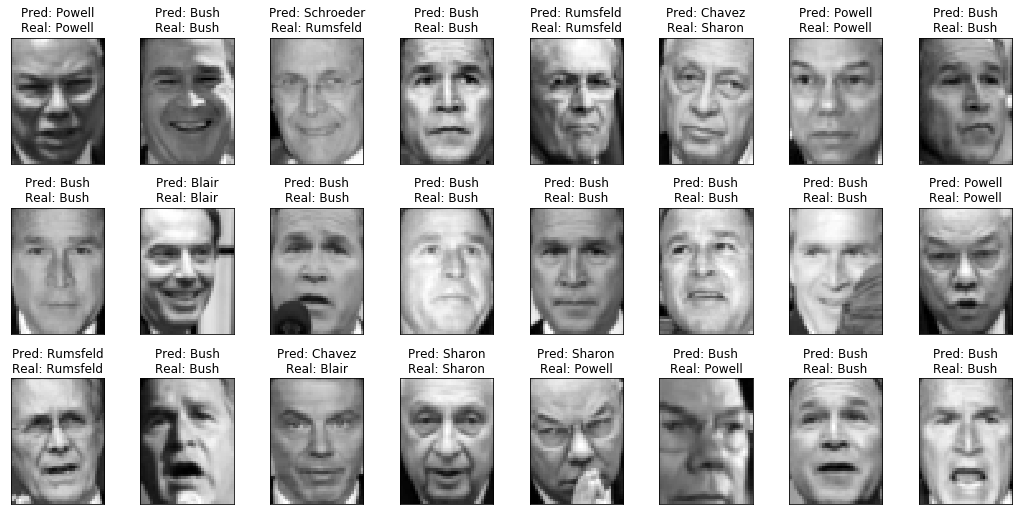

In [0]:
#PREDICCION Y TESTING
Xtest = Xtest/255.
Xtest = Xtest.reshape((Xtest.shape[0], h, w, 1))

Ypred = model3.predict(Xtest)
#Volverlo de notacion 1 de K a  notacion entera

Ypred_entero = []
for value in Ypred:
  Ypred_entero.append(np.argmax(value))

acc = accuracy_score(Ytest ,Ypred_entero)
print("Conf mat: \n", confusion_matrix(Ytest, Ypred_entero))
print("Accuracy =", acc)
titulos = titles(np.asarray(Ypred_entero), Ytest)
plot_gallery(Xtest, h, w, titles=titulos, n_col= 8)

####Análisis 
Para la anterior arquitectura, en 30 épocas se obtuvo un Accuracy en el entrenamiento de 90.58% y en el testing de 81.3953%, aunque son unos buenos resultados, se ve un decremento del desempeño en el accuracy de ámbos casos (train y test)

##Análisis global Redes Neuronales 

Se puede evidenciar que los modelos con capas de convolución y pooling obtuvieron un desempeño mejor que el modelo inicial de extracción de características, como se menciono anteriormente, esto se debe a que cuentan con una mayor cantidad de parámetros los cuales facilitan la predicción de los rostros 

A continuación se muestra un reporte de los accuracy obtenidos en los tres acercamientos 


Modelo | Características | Accuracy 
--- | --- | --- 
1 | Extracción de características con PCA<br># Características = 220<br>Alpha = 0.001<br>Hidden Layer Sizes = (512)<br>Learning rate Init = 0.001 | 0.763565
2 | Extracción de características con capas de convolución<br>3 Capas de convolución y pooling<br>Una capa densa de 512 neuronas | 0.856589
3 | Extracción de caracaterísticas con capas de convolución<br>2 Capas de convolución y pooling<br>Una capa densa de 1024 neuronas | 0.837209
4 | Extracción de características con capas de convolución<br>3 Capas de convolución y pooling<br>4 capas densas de 64, 64, 128 y 128 neuronas respectivamente | 0.813953


$\bf{\mu}_{acc} = 0.817829$

$\bf{\sigma}_{acc} = 0.03477$

Se puede inferir de los resultados que, para este problema, el mejor modelo fue el segundo, con solo una capa densa de 512 neuronas y 3 capas de convolución y pooling, se tenía una hipótesis la cual era que entre más capas mejor sería el desempeño, a partir del resultado, la hipótesis fue descartada

##Parte 2: Máquinas de vectores de soporte 


En esta sección, gracias a GridSearchCV, se puede realizar la variación de parámetros sin la necesidad de escribir mucho código, en esta cuadrícula quedarán compilados todos los modelos y variaciones que se realizarán 

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


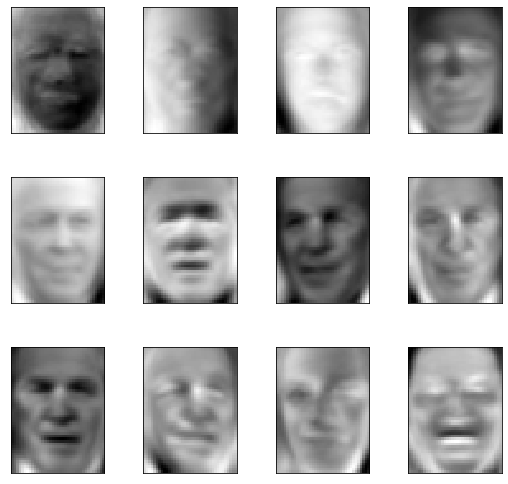

In [0]:
from sklearn.svm import SVC
Xtrain, Xtest, Ytrain, Ytest = train_test_split(data, target, test_size = 0.2, random_state = 51)
Xtrain = Xtrain/255.
Xtest = Xtest/255.
n_components = 100

pca = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True).fit(Xtrain)

eigenfaces = pca.components_.reshape((n_components, h, w))
plot_gallery(eigenfaces, h, w)
X_train_pca = pca.transform(Xtrain)
X_test_pca = pca.transform(Xtest)
param_grid = {'C': [1, 1e3, 1e4],
              'gamma': [ 0.01, 0.1, 0.005], 
              'kernel' : ['rbf', 'sigmoid'],
              }
clf = GridSearchCV(SVC(class_weight='balanced', random_state = 51),
                   param_grid, cv=5)
clf = clf.fit(X_train_pca, Ytrain)


Mejor estimador encontrado:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.005, kernel='rbf',
    max_iter=-1, probability=False, random_state=51, shrinking=True, tol=0.001,
    verbose=False)
Accuracy =  0.8449612403100775
Confusion Matrix 
 [[  8   2   2   2   0   0   0]
 [  1  42   0   2   0   0   0]
 [  1   1  18   3   1   1   0]
 [  1   3   1 100   0   0   1]
 [  0   1   1   4  13   0   3]
 [  0   1   0   4   1  15   0]
 [  0   0   0   2   1   0  22]]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: This function is deprecated. Please call randint(0, 257 + 1) instead
  """


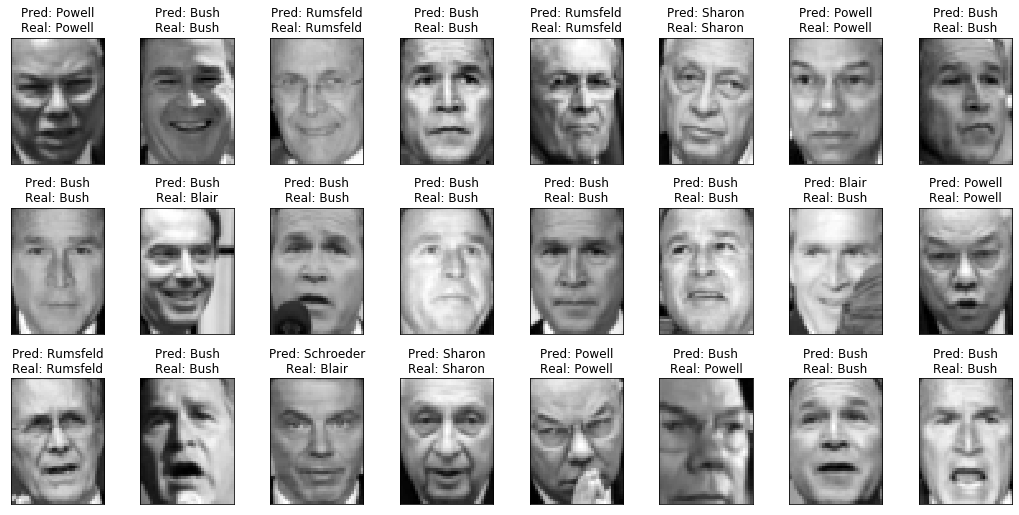

In [0]:
print("Mejor estimador encontrado:")
print(clf.best_estimator_)
Ypred = clf.predict(X_test_pca)
print("Accuracy = ", accuracy_score(Ytest, Ypred))
print("Confusion Matrix \n", confusion_matrix(Ytest, Ypred))
titulos = titles(Ypred, Ytest)
plot_gallery(Xtest, h, w, titles=titulos, n_col= 8)

##Análisis Máquinas de Vectores de Soporte 

A continuación se uestra una tabla que compila los resultados de los hiperparámetros y el accuracy al variar el número de componentes a extraer a partir de PCA 


Modelo |N_components | Características | Accuracy 
---|--- | --- | ---
1|20 | Kernel = rbf<br>C = 1 <br> $\gamma = 0.1$|0.697674
2|50 | Kernel = rbf<br>C = 1000 <br> $\gamma = 0.01$|0.837209
3|100 | Kernel = rbf<br>C = 1000 <br> $\gamma = 0.005$|0.852713
4|150 | Kernel = rbf<br>C = 1000 <br> $\gamma = 0.005$|0.82170
5|280 | Kernel = sigmoide<br>C = 1 <br> $\gamma = 0.005$|0.70155
6|300 | Kernel = sigmoide<br>C = 1 <br> $\gamma = 0.005$|0.68217


$\bf{\mu}_{acc} = 0.76550266$

$\bf{\sigma}_{acc} = 0.0725$

En estos resultados se pueden evidenciar varios elementos muy interesantes:

1.Podría pensarse que los hiperparámetros del mejor estimador siempre son los mismos sin importar el número de características que se extraigan a través de PCA, sin embargo, con los resultados obtenidos se puede evidenciar que tanto la función kernel como C y gamma cambian dependiendo de los componentes.

2.Podría pensarse que entre más componentes se extraigan, mejor será el desempeño, no obstante, con los resultados se puede observar que luego de 100 parámetros, el desempeño comienza a disminuir. Esto puede deberse a que,para el caso de más de 150 componentes, se están tomando en cuenta componentes que no son relevantes para definir de quién es el rostro, sino que estos solo están aportando ruido. Y que para el caso de menos de 50 componentes, no se tiene el número de características suficientes para poder diferenciar algunas caras. 

A partir de los resultados, puede concluirse que para este caso, el mejor modelo para clasificar los rostros es el modelo 3, con 100 características.

#Comparación Redes Neuronales con máquinas de vectores de soporte 


A continuación se muestra una tabla con el mejor resultado de accuracy para la red neuronal y el mejor resultado de accuracy para la SVM 

Modelo | Accuracy 
--- | ---
Red Neuronal |  0.856589
SVM | 0.852713 

$\bf{\mu}_{acc} = 0.854651$

$\bf{\sigma}_{acc} = 0.001938$

Se puede evidenciar que ámbos desempeños son muy parecidos, pero en su arquitectura son muy diferentes. 

El modelo de la red neuronal con el que se obtuvo este desempeño fue una red con varias capas de convolución y pooling, y luego una capa densa de 512 neuronas, esto da como resultado 289,543 parámetros, lo que, en tiempo de computo se ve reflejado, en cambio, para la SVM, se tienen solo 100 parámetros, esto es una diferencia significante. 

Si se desea realizar pruebas a partir de una base de datos, y maximizar el accuracy lo más posible no es una prioridad, será mejor usar una SVM, ya que tiene muchos menos parámetros, lo cual también repercute en que no se necesita un dataset tan grande. Pero si se desea tener un accuracy muy elevado, se pueden probar diversas arquitecturas de una red neuronal, la cual tendrá muchos más parametros pero comunmente se trndrá un mejor desempeño. 